In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical, iter_or_rep
from energyflow.archs.efn import construct_input, construct_pfn_weight_mask, construct_latent, construct_dense
from energyflow.archs.archbase import _get_act_layer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Input, Lambda, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import tensorcircuit as tc
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

Please first ``pip install -U cirq`` to enable related functionality in translation module


('complex128', 'float64')

In [4]:
# tf.compat.v1.disable_eager_execution()
tf.executing_eagerly()

True

In [5]:
################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 7500, 1000, 1500
# train, val, test = 1000000, 200000, 200000
use_pids = True

# load data
X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3, error_on_unknown=False)
else:
    X = X[:,:,:3]

Loaded quark and gluon jets


In [13]:
n_layers = 2
n_qubits = 4

In [14]:
def drc(x, weights, in_shape):
    x = tc.backend.cast(x, "float64")
    c = tc.Circuit(n_qubits)
    
    steps = in_shape//3
    for q in range(n_qubits):
        c.h(q)
    
    for l in range(n_layers):
        for q in range(n_qubits):
            for i in range(steps):
                z = x[3*i:3*i+3]* weights[l,q,0,3*i:3*i+3] + weights[l,q,1,3*i:3*i+3]
                c.rz(q, theta=z[0])
                c.ry(q, theta=z[1])
                c.rz(q, theta=z[2])
                
        for q in range(n_qubits-1):
            c.cnot(q, q+1)
    
#     return tc.backend.abs(c.state())**2
    return tc.backend.real(tc.backend.stack([c.expectation_ps(z=[i]) for i in range(n_qubits)]))

In [15]:
# network architecture parameters
Phi_sizes, F_sizes = (6, 10, 128), (8, 9, 100)
mask_val = 0
latent_dropout = 0.0
input_dim = X.shape[-1]
output_dim = 2
output_act = 'softmax'

# compilation
compile_opts = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'metrics': ['acc']
}

In [16]:
# import tensorflow.keras.backend as K
# from functools import partial

# class HQCPFN(tf.keras.Model):

#     def __init__(self, hidden=3):
#         super().__init__()

#         assert hidden % 3 == 0, 'hidden has to be multipe of 3'
#         d_layer = Dense(hidden,
#                         kernel_initializer='he_uniform',
#                         activation='relu')
#         self.tdist_layer = TimeDistributed(d_layer, name='tdist')

#         # define a function which maps the given mask_val to zero
#         def pfn_mask_func(X, mask_val=mask_val):
#             # map mask_val to zero and return 1 elsewhere
#             return K.cast(K.any(K.not_equal(X, mask_val), axis=-1), K.dtype(X))

#         self.mask_layer = Lambda(pfn_mask_func, name='mask')

#         # DATA REUPLOADING LAYER
#         q_layer = tc.keras.QuantumLayer(partial(drc, in_shape=hidden),
#                                         weights_shape=(n_layers, n_qubits, 2,
#                                                        hidden))

#         q_layer.compute_output_shape = lambda input_shape: (input_shape[0], 2**
#                                                             n_qubits)
#         self.qtdist_layer = TimeDistributed(q_layer, name='q_layer')

#         self.dot_layer = Dot(1, name='sum')

#         # Final dense heads
#         sizes = [10,]
#         self.dense_layers = [
#             Dense(size, kernel_initializer='he_uniform', activation='relu')
#             for size in sizes
#         ]
        
#         # classification head
#         self.head = Dense(2, kernel_initializer='he_uniform', activation='softmax')

#     def call(self, input_tensor):
#         x = self.tdist_layer(input_tensor)
#         x = self.qtdist_layer(x)

#         mask_x = self.mask_layer(input_tensor)
#         x = self.dot_layer([mask_x, x])
        
#         for layer in self.dense_layers:
#             x = layer(x)
        
#         x = self.head(x)
#         return x

#     def build_graph(self, raw_shape):
#         x = tf.keras.Input(shape=raw_shape)
#         return tf.keras.Model(inputs=[x], outputs=self.call(x))


# hqcpfn = HQCPFN()
# hqcpfn.compile(**compile_opts)
# hqcpfn.build_graph((139, 4)).summary()

In [17]:
import tensorflow.keras.backend as K
from functools import partial

class HQCEndPFN(tf.keras.Model):

    def __init__(self, hidden=3):
        super().__init__()

        assert hidden % 3 == 0, 'hidden has to be multipe of 3'
        
        sizes = [100,100,128]
        self.initial_dense_layers = [
            TimeDistributed(Dense(size, kernel_initializer='he_uniform', activation='relu'), name=f'tdist_{i}')
            for i, size in enumerate(sizes)
        ]
        
        # define a function which maps the given mask_val to zero
        def pfn_mask_func(X, mask_val=mask_val):
            # map mask_val to zero and return 1 elsewhere
            return K.cast(K.any(K.not_equal(X, mask_val), axis=-1), K.dtype(X))

        self.mask_layer = Lambda(pfn_mask_func, name='mask')
        
        self.dot_layer = Dot(1, name='sum')
        self.d_layer = Dense(hidden, kernel_initializer='he_uniform', activation='tanh')

        # DATA REUPLOADING LAYER
        self.q_layer = tc.keras.QuantumLayer(partial(drc, in_shape=hidden),
                                        weights_shape=(n_layers, n_qubits, 2,
                                                       hidden))

        self.q_layer.compute_output_shape = lambda input_shape: (input_shape[0], n_qubits)
        
        # classification head
        self.head = Dense(2, kernel_initializer='he_uniform', activation='softmax')

    def call(self, input_tensor):
        
        x = input_tensor
        for layer in self.initial_dense_layers:
            x = layer(x)

        mask_x = self.mask_layer(input_tensor)
        
        x = self.dot_layer([mask_x, x])
        x = self.d_layer(x)
        x = self.q_layer(x)
        x = self.head(x)
        return x

    def build_graph(self, raw_shape):
        x = tf.keras.Input(shape=raw_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


model = HQCEndPFN()
model.compile(**compile_opts)
model.build_graph((139, 4)).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 139, 4)]     0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, 139, 100)     500         ['input_2[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, 139, 100)     10100       ['tdist_0[0][0]']                
                                                                                                  
 mask (Lambda)                  (None, 139)          0           ['input_2[0][0]']                
                                                                                            

Finished preprocessing
Done train/val/test split
Epoch 1/5
15/15 [==============================] - 12s 361ms/step - loss: 0.6920 - acc: 0.5232 - val_loss: 0.6904 - val_acc: 0.4940
Epoch 2/5
15/15 [==============================] - 1s 40ms/step - loss: 0.6873 - acc: 0.5140 - val_loss: 0.6850 - val_acc: 0.4940
Epoch 3/5
15/15 [==============================] - 1s 40ms/step - loss: 0.6795 - acc: 0.5140 - val_loss: 0.6755 - val_acc: 0.4940
Epoch 4/5
15/15 [==============================] - 1s 39ms/step - loss: 0.6665 - acc: 0.6380 - val_loss: 0.6612 - val_acc: 0.7700
Epoch 5/5
15/15 [==============================] - 1s 39ms/step - loss: 0.6497 - acc: 0.7541 - val_loss: 0.6421 - val_acc: 0.7620

PFN AUC: 0.8560124582869855



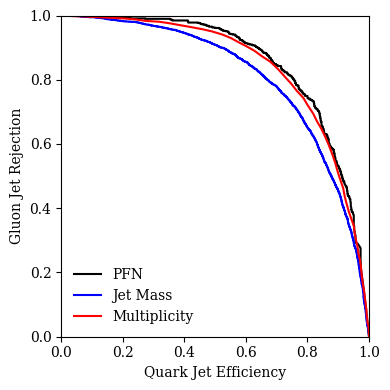

In [18]:
# network training parameters
num_epoch = 5
batch_size = 500

################################################################################

print('Finished preprocessing')

# do train/val/test split
(X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X,
                                                              Y,
                                                              val=val,
                                                              test=test)

print('Done train/val/test split')
# print('Model summary:')

# build architecture
# pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model

model.fit(X_train,
           Y_train,
           epochs=num_epoch,
           batch_size=batch_size,
           validation_data=(X_val, Y_val),
           verbose=1)

# pfn.fit(X_train, Y_train,
#         epochs=num_epoch,
#         batch_size=batch_size,
#         validation_data=(X_val, Y_val),
#         verbose=1)

# get predictions on test data
preds = model.predict(X_test, batch_size=1000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()